# Coding Assignment - 1

#### Authors:
+ Yogananth Mahalingam - ym24
+ Qi Zhou
+ Derek Zhang

#### Contributions:
+ Part 1: 
Yoga & Qi worked on it independently. Brainstormed together & created the final version.

+ Part 2: 
Yoga worked on it. Brainstormed & discussed with Qi for additional inputs.

+ Part 3: 
Qi worked on it. Yoga did a review.

+ Part 4: 

+ Part 5: 
    

In [773]:
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn import linear_model as lm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import scipy.stats as ss

np.random.seed(9719)


## Part 1: Generate Data

### 1.1 Generate the 20 centers, 10 for each group.

In [774]:
csize = 10 
s = np.sqrt(1/5)
mean = np.array([0, 0])
cov = np.array([[s, 0], 
                [0, s]])

# s = 4;      
# cov = np.array([[2, 1], 
#                 [1, 2]])

p = 2      

distr = ss.multivariate_normal(cov = cov, mean = mean)

m1 = distr.rvs(size = csize) + np.array([0, 2])
m0 = distr.rvs(size = csize) + np.array([2, 0])

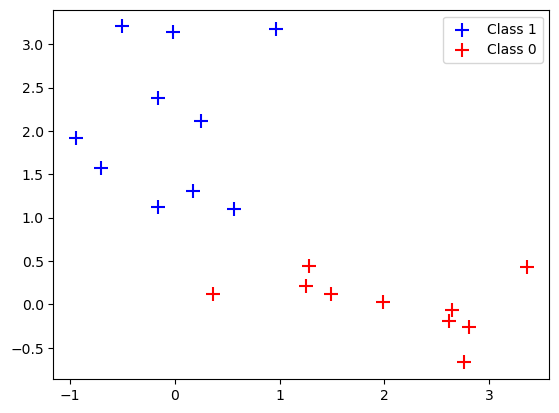

In [775]:
plt.scatter(m1[:,0], m1[:,1], marker = '+', s = 100, c = "blue", label='Class 1')
plt.scatter(m0[:,0], m0[:,1], marker = '+', s = 100, c = "red", label='Class 0')

plt.legend()
plt.show()

### (Comparison study) Generate training & test data with visualization using Normal distribution

In [776]:
n = 100
# Randomly allocate the n samples for class 1  to the 10 clusters
id1 = np.random.randint(csize, size = n)
id0 = np.random.randint(csize, size = n)

# sd for generating data  
s = np.sqrt(float(1)/5) 

traindata = np.random.normal(size = (2 * n, p)) * s \
            + np.concatenate([m1[id1,:], m0[id0,:]])

ytrain = np.concatenate(([1]*n, [0]*n))

In [777]:
N = 5000
# Randomly allocate the n samples for class 1  to the 10 clusters
id1 = np.random.randint(csize, size = N)
id0 = np.random.randint(csize, size = N)

# sd for generating data  
s = np.sqrt(float(1)/5) 

testdata = np.random.normal(size = (2 * N, p)) * s \
            + np.concatenate([m1[id1,:], m0[id0,:]])

ytest = np.concatenate(([1]*N, [0]*N))

[-0.06209018  2.10728817]
[ 1.90564041 -0.02353625]


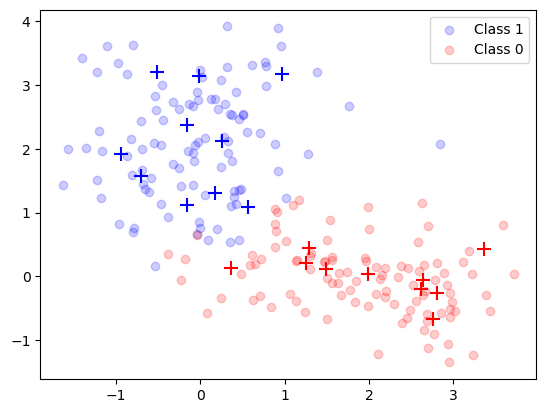

In [778]:
print(np.average(traindata[:n], axis=0))
print(np.average(traindata[n:], axis=0))

plt.scatter(traindata[:n, 0], traindata[:n, 1], c = "blue", alpha=0.2, label='Class 1')
plt.scatter(traindata[n:, 0], traindata[n:, 1], c = "red", alpha=0.2, label='Class 0')

plt.scatter(m1[:,0], m1[:,1], marker = '+', s = 100, c = "blue")
plt.scatter(m0[:,0], m0[:,1], marker = '+', s = 100, c = "red")

plt.legend()
plt.show()

[-0.04949506  2.12085268]
[2.06356676 0.00919386]


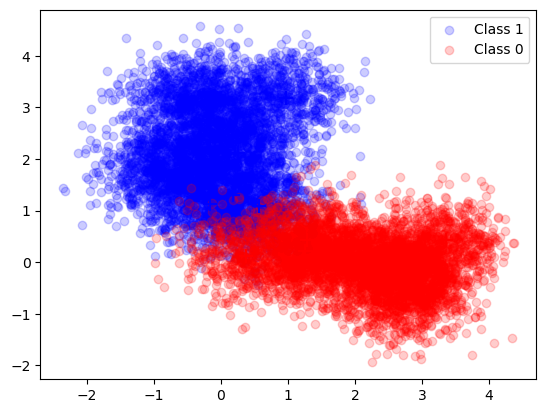

In [779]:
print(np.average(testdata[:N], axis=0))
print(np.average(testdata[N:], axis=0))

plt.scatter(testdata[:N, 0], testdata[:N, 1], c = "blue", alpha=0.2, label='Class 1')
plt.scatter(testdata[N:, 0], testdata[N:, 1], c = "red", alpha=0.2, label='Class 0')

plt.scatter(m1[:,0], m1[:,1], marker = '+', s = 100, c = "blue")
plt.scatter(m0[:,0], m0[:,1], marker = '+', s = 100, c = "red")


plt.legend()
plt.show()

### 1.2 Generate training & test data, with mixture distribution .

In [780]:
def mixture_distribution_rvs(centers, distr, size):
    rvs = np.array([np.average(distr.rvs(size = centers.shape[0]), axis=0) for i in range(size)])
    rvs = rvs + np.average(centers, axis=0)
    return rvs

# print(mixture_distribution_rvs(m1, distr, 10))
# print("-------")
# print(mixture_distribution_rvs(m0, distr, 10))

In [781]:
n = 100
# Randomly allocate the n samples for class 1  to the 10 clusters
id1 = np.random.randint(csize, size = n)
id0 = np.random.randint(csize, size = n)

traindata = np.concatenate([mixture_distribution_rvs(m1, distr, n), mixture_distribution_rvs(m0, distr, n)]) 

ytrain = np.concatenate(([1]*n, [0]*n))

In [782]:
N = 5000
# Randomly allocate the n samples for class 1  to the 10 clusters
id1 = np.random.randint(csize, size = N)
id0 = np.random.randint(csize, size = N)

testdata = np.concatenate([mixture_distribution_rvs(m1, distr, N), mixture_distribution_rvs(m0, distr, N)]) 

ytest = np.concatenate(([1]*N, [0]*N))

### 1.3 Visulization

[-0.06562969  2.10153267]
[2.11961777 0.01285646]


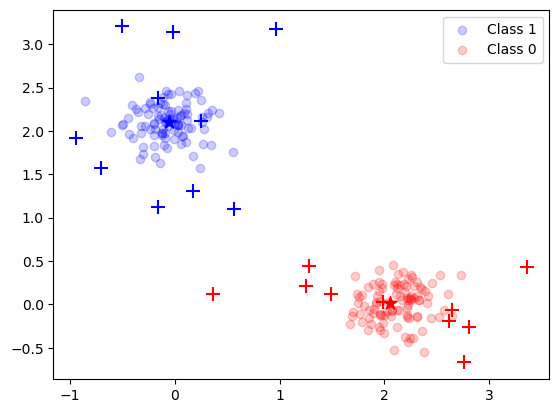

In [783]:
print(np.average(traindata[:n], axis=0))
print(np.average(traindata[n:], axis=0))

plt.scatter(traindata[:n, 0], traindata[:n, 1], c = "blue", alpha=0.2, label='Class 1')
plt.scatter(traindata[n:, 0], traindata[n:, 1], c = "red", alpha=0.2, label='Class 0')

plt.scatter(m1[:,0], m1[:,1], marker = '+', s = 100, c = "blue")
plt.scatter(m0[:,0], m0[:,1], marker = '+', s = 100, c = "red")

plt.scatter(np.average(m1, axis=0)[0], np.average(m1, axis=0)[1], marker = '*', s = 100, c = "blue")
plt.scatter(np.average(m0, axis=0)[0], np.average(m0, axis=0)[1], marker = '*', s = 100, c = "red")

# plt.scatter([0], [2], marker = '*', s = 100, c = "blue")
# plt.scatter([2], [0], marker = '*', s = 100, c = "red")

plt.legend()
plt.show()

[-0.05227903  2.10476461]
[2.05536111 0.01357086]


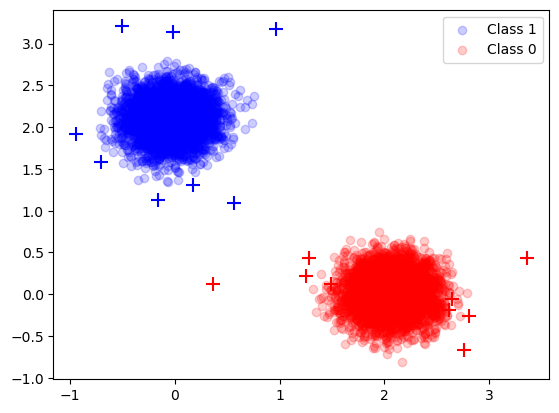

In [784]:
print(np.average(testdata[:N], axis=0))
print(np.average(testdata[N:], axis=0))

plt.scatter(testdata[:N, 0], testdata[:N, 1], c = "blue", alpha=0.2, label='Class 1')
plt.scatter(testdata[N:, 0], testdata[N:, 1], c = "red", alpha=0.2, label='Class 0')

plt.scatter(m1[:,0], m1[:,1], marker = '+', s = 100, c = "blue")
plt.scatter(m0[:,0], m0[:,1], marker = '+', s = 100, c = "red")

plt.scatter(np.average(m1, axis=0)[0], np.average(m1, axis=0)[1], marker = '*', s = 100, c = "blue")
plt.scatter(np.average(m0, axis=0)[0], np.average(m0, axis=0)[1], marker = '*', s = 100, c = "red")

# plt.scatter([0], [2], marker = '*', s = 100, c = "blue")
# plt.scatter([2], [0], marker = '*', s = 100, c = "red")

plt.legend()
plt.show()

## Part 2: kNN

### 2.1 kNN implementation from scratch, with handling for Distance ties & Voting ties

In [785]:
# Final

def eucledian_distance(A, B):
    M = A.shape[0]
    N = B.shape[0]
    
    A_dots = (A*A).sum(axis=1).reshape((M,1))*np.ones(shape=(1,N))
    B_dots = (B*B).sum(axis=1)*np.ones(shape=(M,1))
    
    D_squared =  A_dots + B_dots -2*A.dot(B.T)
    
    return D_squared
    
def custom_knn(train_data, test_data, ytrain, k):
    distance_matrix = eucledian_distance(test_data, train_data)
    
    top_k_indices = np.argsort(distance_matrix, axis=1)
    ytest_pred = ytrain[top_k_indices]
    voting_ties_ytest_pred = np.copy(ytest_pred)
    
    """
    Prepare the Distance Matrix for kNN
    Identify the top k points
    
    Distance Ties: For those k points that have distance ties & falling outside of k. 
    Include them as well for computing Nearest Neighbor.
    This would mean, we are using k or more points for prediction
    
    Mask rest of the points, outside of k, in the distance matrix, by setting it as NaN.
    """
    kth_distance = np.sort(distance_matrix)[:, k-1]
    distance_matrix = np.where((distance_matrix <= np.transpose([kth_distance])), distance_matrix, np.nan)
    distance_matrix = np.sort(distance_matrix)
    
    """
    Voting ties : 
    Prepare a Distance matrix with one Neighbor less (k-1), by masking the last of k-neighbor as NaN.
    """
    voting_ties_distance_matrix = np.copy(distance_matrix)
    voting_ties_distance_matrix[:, np.nanargmax(voting_ties_distance_matrix, axis=1) ] = np.nan
    
    """
    Count the predictions & choose the majority as the predicted value
    """
    ytest_pred = ytest_pred * (distance_matrix + 0.1)
    
    ytest_pred_0_count = np.count_nonzero(ytest_pred == 0, axis = 1)
    ytest_pred_1_count = np.count_nonzero(ytest_pred > 0, axis = 1)
    
    ytest_pred = ytest_pred_1_count > ytest_pred_0_count
    ytest_pred = ytest_pred.astype(int)
    
    """
    Predict with Voting Ties Distance Matrix
    """
    voting_ties_ytest_pred = voting_ties_ytest_pred * (voting_ties_distance_matrix + 0.1)
    
    voting_ties_ytest_pred_0_count = np.count_nonzero(voting_ties_ytest_pred == 0, axis = 1)
    voting_ties_ytest_pred_1_count = np.count_nonzero(voting_ties_ytest_pred > 0, axis = 1)
    
    voting_ties_ytest_pred = voting_ties_ytest_pred_1_count > voting_ties_ytest_pred_0_count
    voting_ties_ytest_pred = voting_ties_ytest_pred.astype(int)
    
    """
    Prepare the final prediction by merging the predicted values, with the Voting tie predictions 
    for the ones that have voting ties
    """
    ytest_pred_mask = (ytest_pred_1_count == ytest_pred_0_count)
    final_ytest_pred = np.ma.sum([np.ma.array([ytest_pred], mask=ytest_pred_mask), np.ma.array([voting_ties_ytest_pred], mask=np.invert(ytest_pred_mask))], axis=0)
    
    return final_ytest_pred.flatten()



### 2.2 Distance Ties & Voting ties

<b>Distance Ties:</b>

<li>After selecting k nearest neighbors, if there are still points outside of k, with the same distance.
<li>Include those points as well, for computing Nearest Neighbor.
<li>This would mean, we are using k or more points for prediction

<b>Voting Ties:</b>

<li> Voting tie can be handled by having the farthest neighbor among k, removed from voting process.
<li> With one less neighbor, tie is guaranteed to be breaken.
<li> Now, select the majority value as prediction.


### 2.3 Testing

<li>Tested & Compared the predicted results of Custom kNN & sklearn version.
<li> Predicted values & Confusion matrix generated for both the versions looks similar.

In [786]:
myk = [5, 3, 1]

train_err_knn = []
test_err_knn = []

for k in myk:
    myknn = knn(n_neighbors = k)
    myknn.fit(traindata, ytrain)
    ytest_pred_sk = myknn.predict(testdata)
    cm_sk = confusion_matrix(ytest_pred_sk, ytest)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm_sk)
#     disp.plot()
    ytest_pred_cm = custom_knn(traindata, testdata, ytrain, k)
    cm_cm = confusion_matrix(ytest_pred_cm, ytest)
    print("k=" + str(k))
    print("ytest=" + str(ytest))
    print("ytest_pred_sk=" + str(ytest_pred_sk))
    print("ytest_pred_cm=" + str(ytest_pred_cm))
    print("cm_sk \n" + str(cm_sk))
    print("cm_cm \n" + str(cm_cm))
    print("---------------------")
    


k=5
ytest=[1 1 1 ... 0 0 0]
ytest_pred_sk=[1 1 1 ... 0 0 0]
ytest_pred_cm=[1 1 1 ... 0 0 0]
cm_sk 
[[5000    0]
 [   0 5000]]
cm_cm 
[[5000    0]
 [   0 5000]]
---------------------
k=3
ytest=[1 1 1 ... 0 0 0]
ytest_pred_sk=[1 1 1 ... 0 0 0]
ytest_pred_cm=[1 1 1 ... 0 0 0]
cm_sk 
[[5000    0]
 [   0 5000]]
cm_cm 
[[5000    0]
 [   0 5000]]
---------------------
k=1
ytest=[1 1 1 ... 0 0 0]
ytest_pred_sk=[1 1 1 ... 0 0 0]
ytest_pred_cm=[1 1 1 ... 0 0 0]
cm_sk 
[[5000    0]
 [   0 5000]]
cm_cm 
[[5000    0]
 [   0 5000]]
---------------------


In [787]:
myk = [5, 3, 1]

train_err_knn = []
test_err_knn = []

for k in myk:
    myknn = knn(n_neighbors = k)
    myknn.fit(traindata, ytrain)
    ytest_pred_sk = myknn.predict(testdata)
    cm_sk = confusion_matrix(ytest_pred_sk, ytest)
    print("k=" + str(k))
    print("ytest=" + str(ytest))
    print("ytest_pred_sk=" + str(ytest_pred_sk))
    print("cm_sk \n" + str(cm_sk))
    print("---------------------")
    


k=5
ytest=[1 1 1 ... 0 0 0]
ytest_pred_sk=[1 1 1 ... 0 0 0]
cm_sk 
[[5000    0]
 [   0 5000]]
---------------------
k=3
ytest=[1 1 1 ... 0 0 0]
ytest_pred_sk=[1 1 1 ... 0 0 0]
cm_sk 
[[5000    0]
 [   0 5000]]
---------------------
k=1
ytest=[1 1 1 ... 0 0 0]
ytest_pred_sk=[1 1 1 ... 0 0 0]
cm_sk 
[[5000    0]
 [   0 5000]]
---------------------


# **Part 3:cvKNN**

Implement KNN classification with K chosen by 10-fold cross-validation from scratch.

Set the candidate K values from 1 to 180. (The maximum candidate K value is 180. Why?)

From now on, you are allowed to use the built-in kNN function from R or Python instead of your own implementation from Part 2.

It is possible that multiple K values give the (same) smallest CV error; when this happens, pick the largest K value among them, since the larger the K value, the simpler the model.

Test your code with the training/test data you just generated. Report your results (on the test data) as a 2-by-2 table and also report the value of the selected K.

In [788]:
Ytrain = ytrain
Ytest = ytest

In [789]:
# Define the number of folds
num_folds = 10
myk_cv = np.arange(1, 181)
n = len(Ytrain)

m = len(myk_cv)
cverr = np.zeros(m)

indices = np.arange(n)
np.random.shuffle(indices)
index_sets = np.array_split(indices, num_folds)

for ifold in range(num_folds):
    train_indices =  np.delete(index_sets, obj=ifold, axis=0).ravel()
    _traindata = traindata[train_indices]
    _Ytrain = Ytrain[train_indices]

    test_indices = index_sets[ifold]
    _testdata = traindata[test_indices]
    _Ytest = Ytrain[test_indices]

    for j in range(m):
        K = myk_cv[j]
        knn_model = knn(K)
        knn_model.fit(_traindata, _Ytrain)
        predict_Y = knn_model.predict(_testdata)
        cverr[j] += sum(predict_Y != _Ytest)


In [790]:
cverr /= float(n)

In [797]:
min_value = np.min(cverr)
indices_of_min = np.where(cverr == min_value)[0]

best_k = myk_cv[indices_of_min[-1]]
best_k


174

In [798]:
knn_model = knn(best_k)
knn_model.fit(traindata, Ytrain)
predict_Y = knn_model.predict(testdata)


In [799]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Ytest, predict_Y)

print ("The best K value is: \n", best_k)
print ("The confusion matrix is: \n",cm)



The best K value is: 
 174
The confusion matrix is: 
 [[5000    0]
 [   0 5000]]
